In [1]:
import pandas as pd
import matplotlib.pylab as plt

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
rcParams['lines.marker'] = 'o'

In [2]:
df = pd.read_csv("time_series.csv", thousands=',')

In [3]:
for i in range(0,len(df.Date) ):
    df.Date[i] = '200'+str((i//12)+1) + '-' + df.Date[i][0:5]

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [4]:
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True) 
df.head()

,Date,Total Sales
0,2001-01-01,120000.0
1,2001-02-01,130000.0
2,2001-03-01,150000.0
3,2001-04-01,160000.0
4,2001-05-01,180000.0


In [5]:
df = df.set_index('Date')

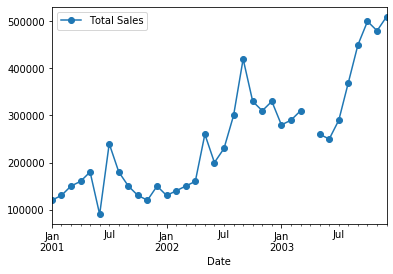

In [6]:
_ = df.plot()

We will take the values before the missing data as training set, and data after it as the test set 

In [7]:
df_n = df[:27]

In [8]:
df_n

,Total Sales
Date,
2001-01-01,120000.0
2001-02-01,130000.0
2001-03-01,150000.0
2001-04-01,160000.0
2001-05-01,180000.0
2001-06-01,90000.0
2001-07-01,240000.0
2001-08-01,180000.0
2001-09-01,150000.0


In [9]:
from statsmodels.tsa.stattools import adfuller, kpss

def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=6).mean()
    movingSTD = timeseries.rolling(window=6).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    result = kpss(timeseries, regression='c')
    print('\nKPSS Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[3].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    

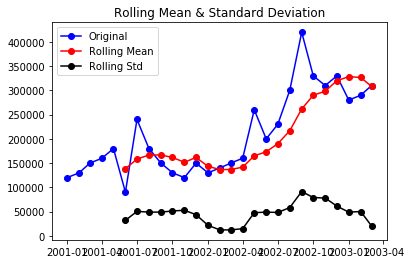

Results of Dickey Fuller Test:
Test Statistic                 -1.696991
p-value                         0.432663
#Lags Used                      0.000000
Number of Observations Used    26.000000
Critical Value (1%)            -3.711212
Critical Value (5%)            -2.981247
Critical Value (10%)           -2.630095
dtype: float64

KPSS Statistic: 0.351367
p-value: 0.098118
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/home/youssef/.local/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


In [10]:
test_stationarity ( df_n['Total Sales'] )

So as we can see next the df is stationary after a single difference (so ARIMA d variable == 1)

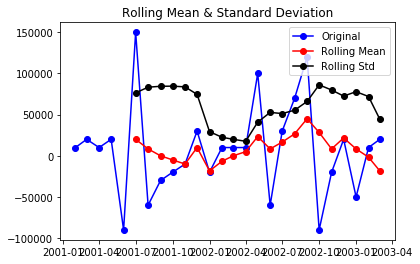

Results of Dickey Fuller Test:
Test Statistic                -7.040153e+00
p-value                        5.875188e-10
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+01
Critical Value (1%)           -3.723863e+00
Critical Value (5%)           -2.986489e+00
Critical Value (10%)          -2.632800e+00
dtype: float64

KPSS Statistic: 0.156773
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/home/youssef/.local/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [11]:
df_nl = (df_n.diff()).dropna()
test_stationarity ( df_nl['Total Sales'] )

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/home/youssef/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


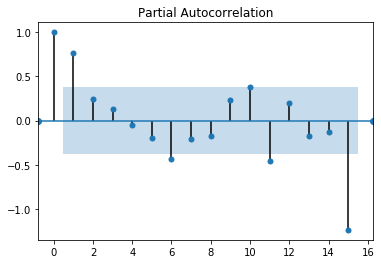

In [13]:
_ = plot_pacf ( df_n['Total Sales'] )

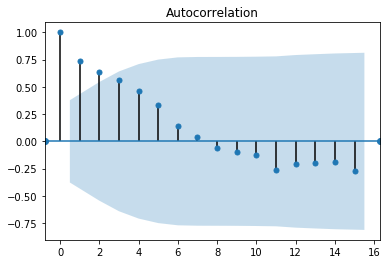

In [14]:
_ = plot_acf ( df_n['Total Sales'] )

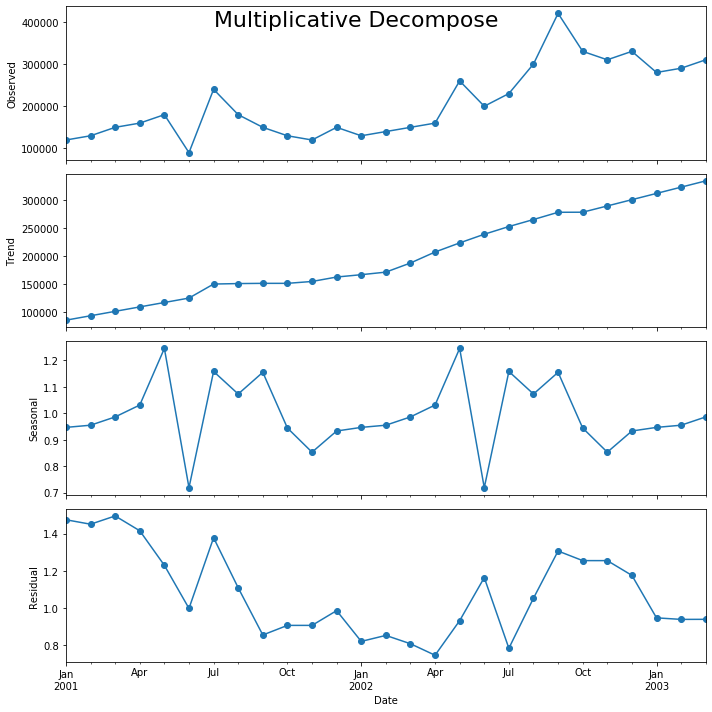

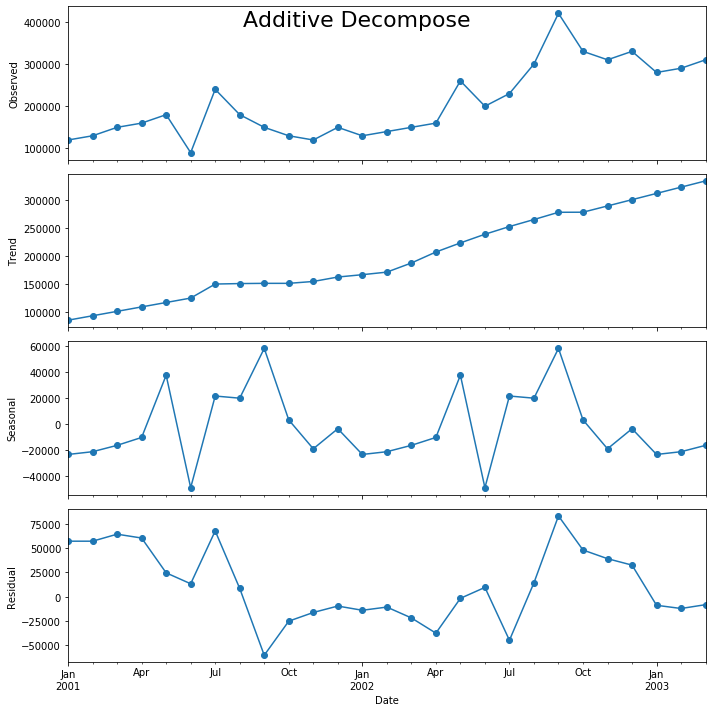

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(df_n['Total Sales'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df_n['Total Sales'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

Seasonal Decomposition Doesn't show much, both multiplicative and additive models seems to leave seasonality patterns at the residual, which unfortunately is a sign that ARIMA model will need to account for seasonality (which it doesn't do)

So basically SARIMA model will be better (as further analysis will show)

In [16]:
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA


model = pm.auto_arima(df_n['Total Sales'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      error_action='ignore',  
                      suppress_warnings=True)

print(model.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   27
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -319.505
Date:                Tue, 11 Feb 2020   AIC                            645.009
Time:                        11:10:49   BIC                            648.784
Sample:                             0   HQIC                           646.096
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.136e+04   7001.013      1.623      0.105   -2362.106    2.51e+04
ma.L1         -0.3944      0.191     -2.068      0.039      -0.768      -0.021
sigma2      3.055e+09      0.026   1.17e+11      0.0

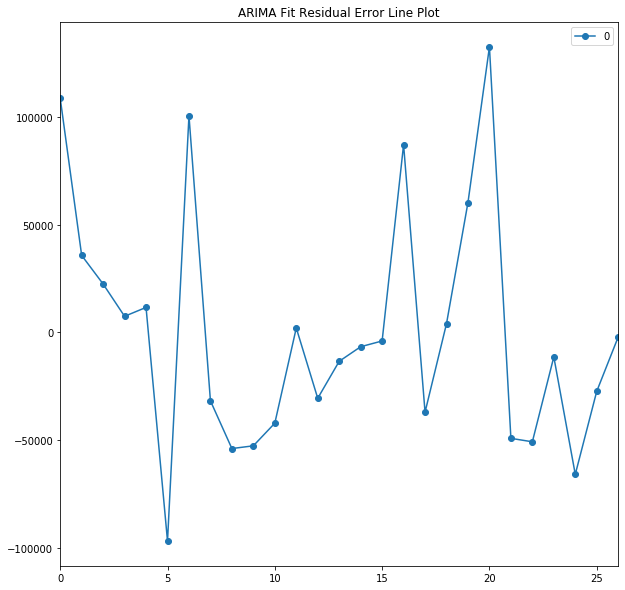

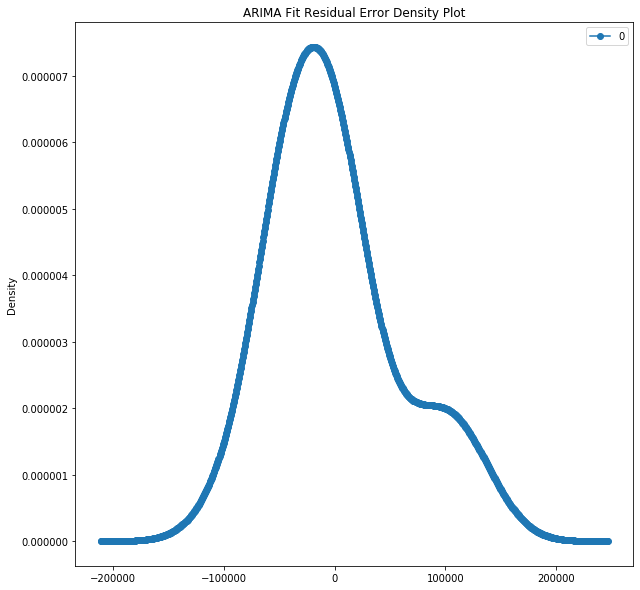

                   0
count      27.000000
mean     -120.103144
std     56565.843942
min    -96792.449476
25%    -39563.864343
50%     -6648.974761
75%     17007.847169
max    132396.122969


In [17]:
# plot residual errors
residuals = pd.DataFrame(model.resid()  )
residuals.plot()
plt.title('ARIMA Fit Residual Error Line Plot')
plt.show()

residuals.plot(kind='kde')
plt.title('ARIMA Fit Residual Error Density Plot')
plt.show()
print(residuals.describe())

In [18]:
from sklearn.metrics import mean_squared_error

X = df.values
#size = int(len(X) * 0.66)
size = 27
train, test = X[0:size], X[size+1:len(X)]
history = [x for x in train]
predictions = list()


In [19]:
model = ARIMA(history, order=(0, 1, 1))
model_fit = model.fit(disp=0)
output = model_fit.forecast()
yhat = output[0]
t = 0

Extrapolating the  Missing Value

In [20]:
test[0] = yhat
predictions.append(yhat)
obs = test[t]
history.append(obs)
print('predicted=%f, expected=%f' % (yhat, obs))

predicted=316624.282205, expected=316624.282205


In [21]:
for t in range(1, len(test)):
	model = ARIMA(history, order=(0, 1, 1))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=323893.207392, expected=250000.000000
predicted=287310.621751, expected=290000.000000
predicted=294905.320864, expected=370000.000000
predicted=342844.751911, expected=450000.000000
predicted=421154.955860, expected=500000.000000
predicted=494319.077536, expected=480000.000000
predicted=494435.927631, expected=510000.000000
Test MSE: 3656589274.678


In-Sample Prediction Model (ARIMA-Based)

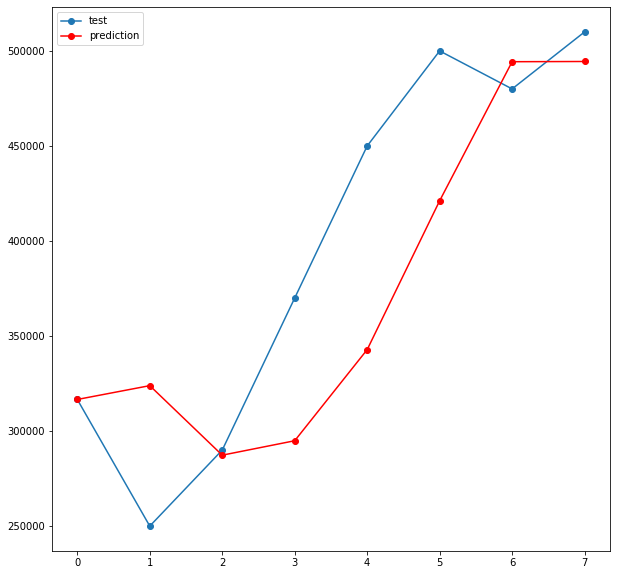

In [22]:
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.legend(['test','prediction'])
plt.show()

Out of sample predictions

/home/youssef/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/youssef/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


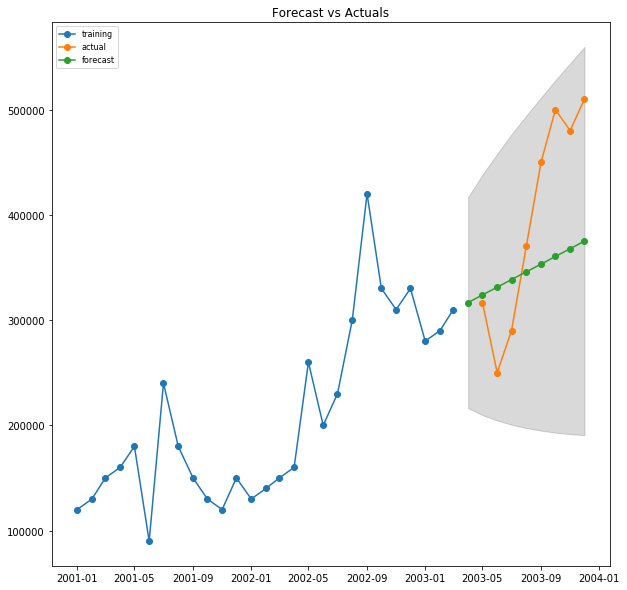

In [23]:
# Build Model

# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(df_n['Total Sales'], order=(0, 1, 1))  
fitted = model.fit(disp=-1)  

n_periods = 9
#fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
#index_of_fc = np.arange(len(df_n), len(df_n)+n_periods)

# Forecast
fc, se, conf = fitted.forecast(9, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=df[27:].index)
lower_series = pd.Series(conf[:, 0], index=df[27:].index)
upper_series = pd.Series(conf[:, 1], index=df[27:].index)

# make series for plotting purpose
#fc_series = pd.Series(fc, index=df[27:].index)
#lower_series = pd.Series(confint[:, 0], index=df[27:].index)
#upper_series = pd.Series(confint[:, 1], index=df[27:].index)

plt.plot(df_n['Total Sales'], label='training')
plt.plot(df[27:], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Plot
#plt.plot(df_n['Total Sales'])
#plt.plot(fc_series, color='darkgreen')
#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

#plt.title("Final Forecast of WWW Usage")
#plt.show()

In [24]:
import pmdarima as pm

In [25]:
seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

df_n['month'] = df_n.index.month

df_ns = pd.merge(df_n, seasonal_index, how='left', on='month')
df_ns.columns = ['value', 'month', 'seasonal_index']

df_ns.index = df_n.index


/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [26]:
df_ns

,value,month,seasonal_index
Date,,,
2001-01-01,120000.0,1,0.946719
2001-02-01,130000.0,2,0.954960
2001-03-01,150000.0,3,0.986338
2001-04-01,160000.0,4,1.031309
2001-05-01,180000.0,5,1.245497
2001-06-01,90000.0,6,0.718509
2001-07-01,240000.0,7,1.158310
2001-08-01,180000.0,8,1.072960
2001-09-01,150000.0,9,1.155089


In [27]:
seasonal_index['Total Sales']

Date
2002-04-01    1.031309
2002-05-01    1.245497
2002-06-01    0.718509
2002-07-01    1.158310
2002-08-01    1.072960
2002-09-01    1.155089
2002-10-01    0.944336
2002-11-01    0.852923
2002-12-01    0.933050
2003-01-01    0.946719
2003-02-01    0.954960
2003-03-01    0.986338
Name: Total Sales, dtype: float64

In [28]:
df_ns['seasonal_index']

Date
2001-01-01    0.946719
2001-02-01    0.954960
2001-03-01    0.986338
2001-04-01    1.031309
2001-05-01    1.245497
2001-06-01    0.718509
2001-07-01    1.158310
2001-08-01    1.072960
2001-09-01    1.155089
2001-10-01    0.944336
2001-11-01    0.852923
2001-12-01    0.933050
2002-01-01    0.946719
2002-02-01    0.954960
2002-03-01    0.986338
2002-04-01    1.031309
2002-05-01    1.245497
2002-06-01    0.718509
2002-07-01    1.158310
2002-08-01    1.072960
2002-09-01    1.155089
2002-10-01    0.944336
2002-11-01    0.852923
2002-12-01    0.933050
2003-01-01    0.946719
2003-02-01    0.954960
2003-03-01    0.986338
Name: seasonal_index, dtype: float64

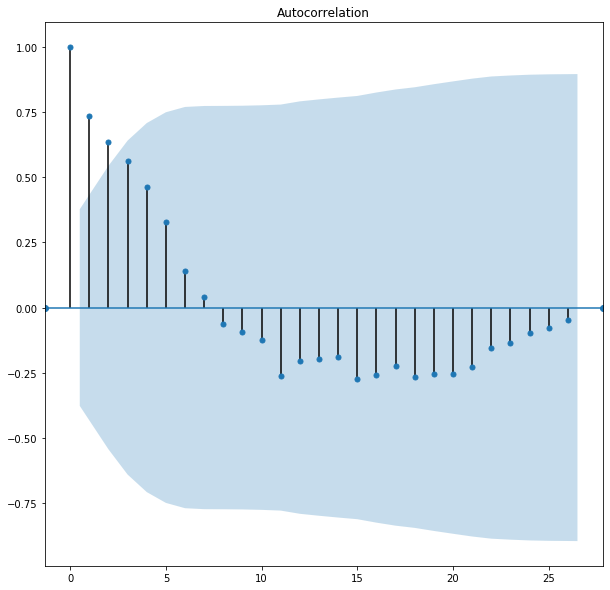

In [29]:
_ = plot_acf ( df_n['Total Sales'], lags=26 )

Data Shows Seasonality, so a SARIMAX Model will fit better (for out-of-sample prediction)

as we see

In [30]:
# SARIMAX Model
sxmodel = pm.auto_arima(df_ns[['value']], exogenous=df_ns[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=357.499, BIC=359.416, Fit time=0.013 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=359.365, BIC=362.561, Fit time=0.310 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=379.784, BIC=381.062, Fit time=0.019 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=357.168, BIC=359.724, Fit time=0.187 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   27
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -174.584
Date:                            Tue, 11 Feb 2020   AIC                            357.168
Time:                                    11:11:43   BIC                            359.724
Sample:                                01-01-2001   HQIC                           356.931
                                     - 03-01-2003                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       1.071e+04   2.24e+04      0.479      0.632   -3.32e+04    5.46e+04
seasonal_index  1.473e-05   2.21e+05   6.68e-11      1.000   -4.32e+05    4.32e+05
ar.S.L12          -0.4374      0.558     -0.784      0.433      -1.531       0.656
sigma2          4.692e+09     11.777   3.98e+08      0.000    4.69e+09    4.69e+09
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 0.71
Prob(Q):                               nan   Prob(JB):                         0.70
Heteroskedasticity (H):               1.67   Skew:                             0.54
Prob(H) (two-sided):                  0.59   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.42e+24. Standard errors may be unstable.
"""

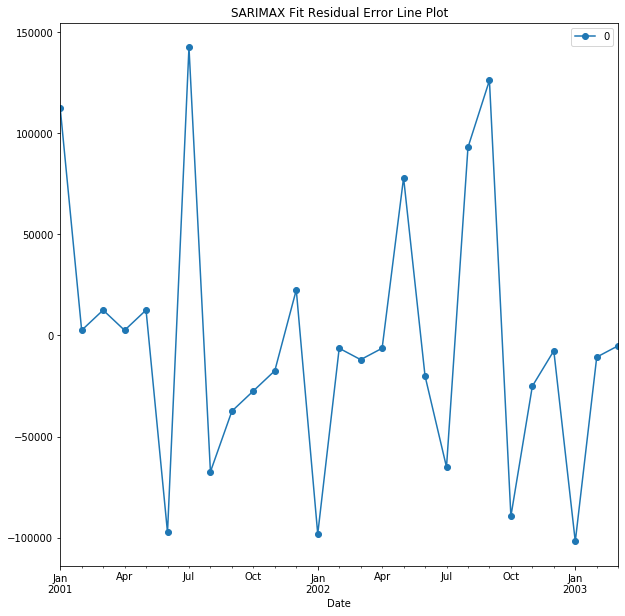

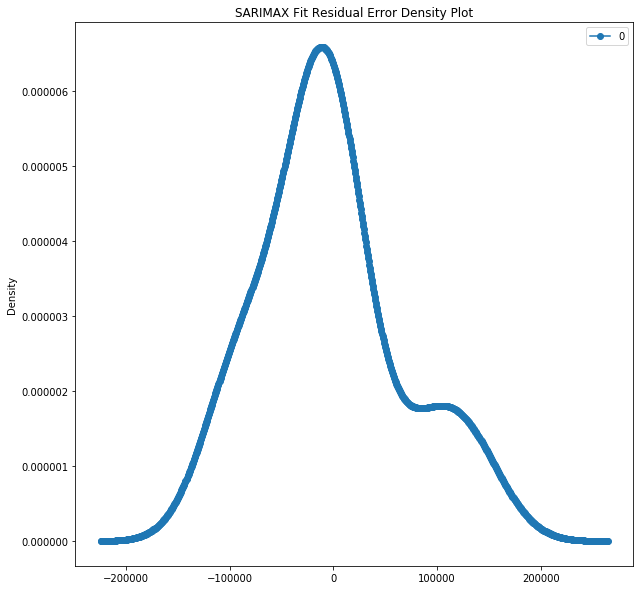

                   0
count      27.000000
mean    -3338.622897
std     66341.554958
min   -101933.741208
25%    -32454.042584
50%     -7594.609184
75%     12545.957413
max    142545.957408


In [31]:
# plot residual errors
residuals = pd.DataFrame(sxmodel.resid())
residuals.plot()
plt.title('SARIMAX Fit Residual Error Line Plot')
plt.show()

residuals.plot(kind='kde')
plt.title('SARIMAX Fit Residual Error Density Plot')
plt.show()
print(residuals.describe())

In [32]:
# Build Model
#from statsmodels.tsa.statespace.sarimax import SARIMAX

 #model = ARIMA(train, order=(3,2,1))  
#model = SARIMAX(df_ns['value'], order=(2, 2, 0), seasonal_order=(1, 0, 0, 12))
#fitted = model.fit(disp=-1)  


import numpy as np

n_periods = 36
fc, confint = sxmodel.predict(n_periods=n_periods,
                              exogenous=np.tile(seasonal_index['Total Sales'], 3).reshape(-1,1) [:n_periods],
                              return_conf_int=True, alpha=0.50)
#index_of_fc = np.arange(len(df_n), len(df_n)+n_periods)

# Forecast
# fc, se, conf = fitted.forecast(9, alpha=0.05)  # 95% conf

In [33]:
np.tile(seasonal_index['Total Sales'], int(n_periods/12) ).reshape(-1,1) [:n_periods]

array([[1.03130935],
       [1.24549695],
       [0.71850868],
       [1.15831013],
       [1.07296026],
       [1.15508933],
       [0.94433554],
       [0.85292276],
       [0.93304969],
       [0.94671926],
       [0.95496008],
       [0.98633798],
       [1.03130935],
       [1.24549695],
       [0.71850868],
       [1.15831013],
       [1.07296026],
       [1.15508933],
       [0.94433554],
       [0.85292276],
       [0.93304969],
       [0.94671926],
       [0.95496008],
       [0.98633798],
       [1.03130935],
       [1.24549695],
       [0.71850868],
       [1.15831013],
       [1.07296026],
       [1.15508933],
       [0.94433554],
       [0.85292276],
       [0.93304969],
       [0.94671926],
       [0.95496008],
       [0.98633798]])

In [34]:
df_ns

,value,month,seasonal_index
Date,,,
2001-01-01,120000.0,1,0.946719
2001-02-01,130000.0,2,0.954960
2001-03-01,150000.0,3,0.986338
2001-04-01,160000.0,4,1.031309
2001-05-01,180000.0,5,1.245497
2001-06-01,90000.0,6,0.718509
2001-07-01,240000.0,7,1.158310
2001-08-01,180000.0,8,1.072960
2001-09-01,150000.0,9,1.155089


In [35]:
# Make as pandas series
#fc_series = pd.Series(fc, index=df[27:].index)
#lower_series = pd.Series(conf[:, 0], index=df[27:].index)
#upper_series = pd.Series(conf[:, 1], index=df[27:].index)

# make series for plotting purpose
fc_series = pd.Series(fc, index=pd.date_range('2003-04-01', periods=n_periods, freq='MS',name='Date'))
lower_series = pd.Series(confint[:, 0], index=pd.date_range('2003-04-01', periods=n_periods, freq='MS',name='Date'))
upper_series = pd.Series(confint[:, 1], index=pd.date_range('2003-04-01', periods=n_periods, freq='MS',name='Date'))

In [36]:
df[27:].index

DatetimeIndex(['2003-04-01', '2003-05-01', '2003-06-01', '2003-07-01',
               '2003-08-01', '2003-09-01', '2003-10-01', '2003-11-01',
               '2003-12-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [37]:
pd.date_range('2003-04-01', periods=12, freq='MS',name='Date')

DatetimeIndex(['2003-04-01', '2003-05-01', '2003-06-01', '2003-07-01',
               '2003-08-01', '2003-09-01', '2003-10-01', '2003-11-01',
               '2003-12-01', '2004-01-01', '2004-02-01', '2004-03-01'],
              dtype='datetime64[ns]', name='Date', freq='MS')

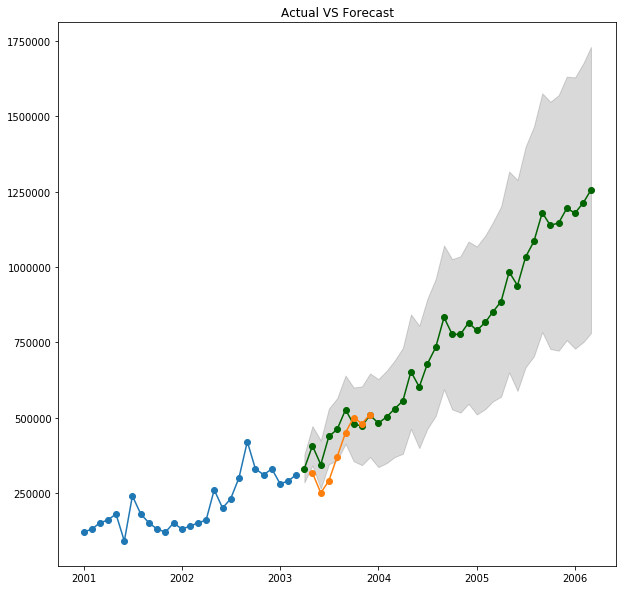

In [38]:
#plt.plot(df_n, label='training')
#plt.plot(df[27:], label='actual')
#plt.plot(fc_series, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.15)
#plt.title('Forecast vs Actuals')
#plt.legend(loc='upper left', fontsize=8)
#plt.show()

# Plot
plt.plot(df_n['Total Sales'])
plt.plot(fc_series, color='darkgreen')
plt.plot(df[27:], label='actual')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

plt.title("Actual VS Forecast")
plt.show()

In [39]:
from statsmodels.stats.diagnostic import het_arch

_, pvalue,_ ,_ = het_arch ( sxmodel.resid() )
pvalue

0.23461305433044696

So as we can see p-value is above the Signficance level, which means the data has Conditional Heteroscedasticity

In [40]:
train

array([[120000.],
       [130000.],
       [150000.],
       [160000.],
       [180000.],
       [ 90000.],
       [240000.],
       [180000.],
       [150000.],
       [130000.],
       [120000.],
       [150000.],
       [130000.],
       [140000.],
       [150000.],
       [160000.],
       [260000.],
       [200000.],
       [230000.],
       [300000.],
       [420000.],
       [330000.],
       [310000.],
       [330000.],
       [280000.],
       [290000.],
       [310000.]])

In [41]:
df_n['Total Sales']

Date
2001-01-01    120000.0
2001-02-01    130000.0
2001-03-01    150000.0
2001-04-01    160000.0
2001-05-01    180000.0
2001-06-01     90000.0
2001-07-01    240000.0
2001-08-01    180000.0
2001-09-01    150000.0
2001-10-01    130000.0
2001-11-01    120000.0
2001-12-01    150000.0
2002-01-01    130000.0
2002-02-01    140000.0
2002-03-01    150000.0
2002-04-01    160000.0
2002-05-01    260000.0
2002-06-01    200000.0
2002-07-01    230000.0
2002-08-01    300000.0
2002-09-01    420000.0
2002-10-01    330000.0
2002-11-01    310000.0
2002-12-01    330000.0
2003-01-01    280000.0
2003-02-01    290000.0
2003-03-01    310000.0
Name: Total Sales, dtype: float64

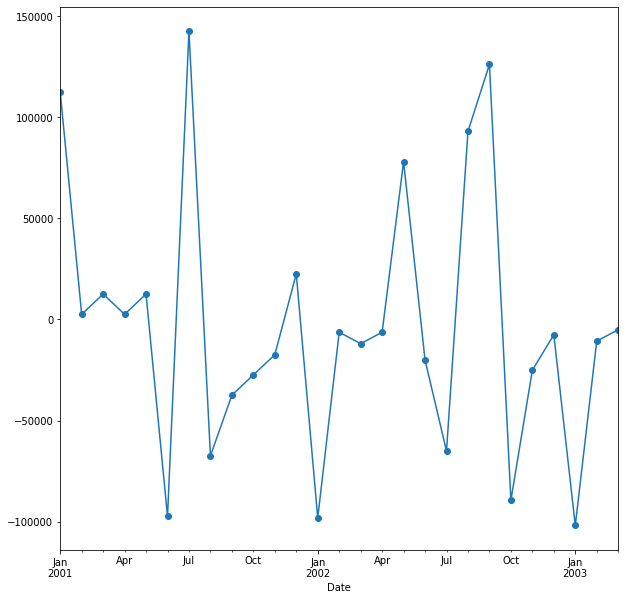

In [42]:
_ = sxmodel.resid().plot()

/home/youssef/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


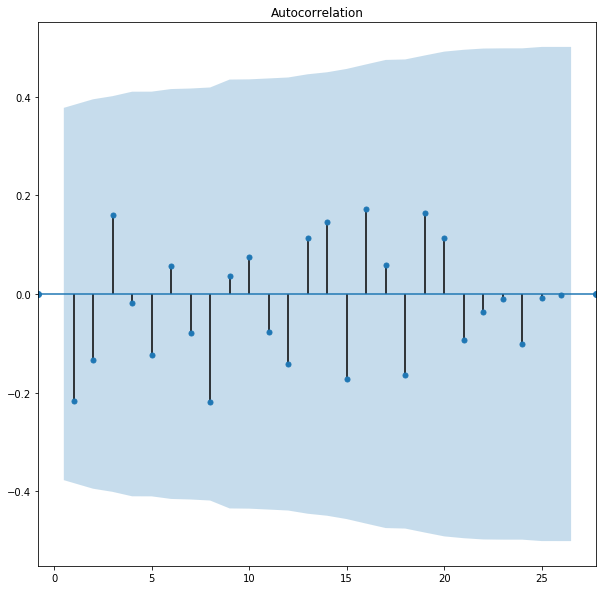

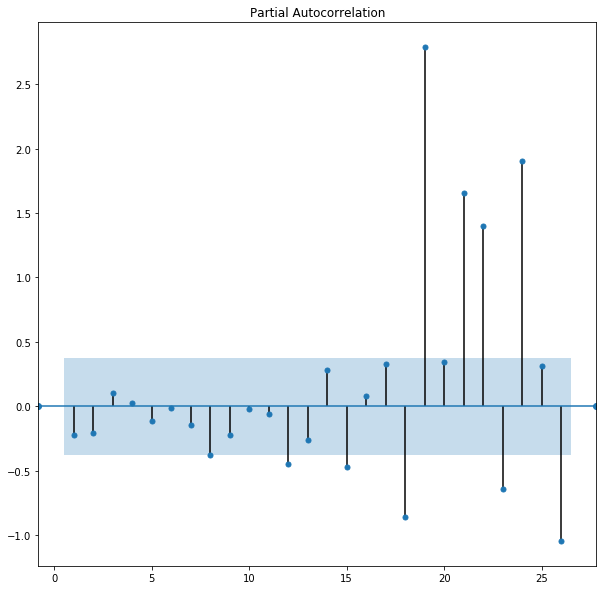

In [43]:
_ = plot_acf  ( sxmodel.resid(), zero=False, lags=26)

_ = plot_pacf ( sxmodel.resid(), zero=False, lags=26)

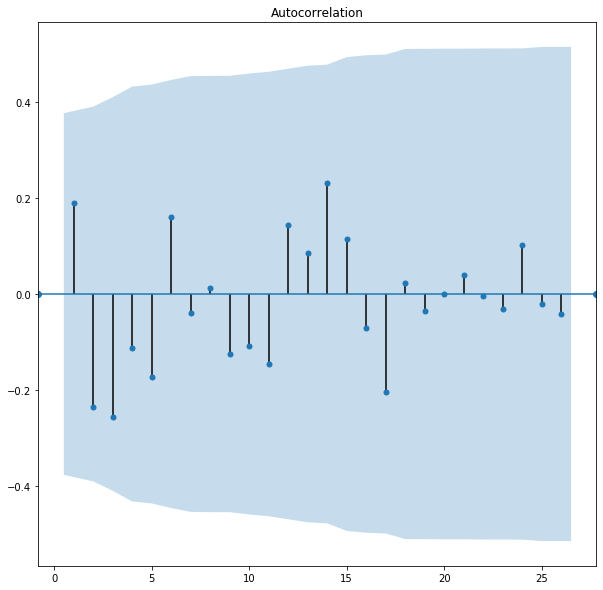

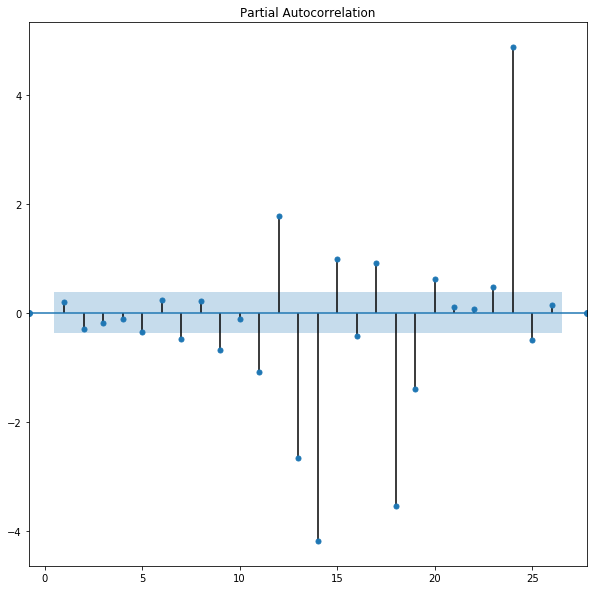

In [44]:
_ = plot_acf  ( sxmodel.resid() ** 2, zero=False, lags=26)

_ = plot_pacf ( sxmodel.resid() ** 2, zero=False, lags=26)

So as we see, there are high signs of correlations in the residuals

In [45]:
from arch import arch_model

model = arch_model(sxmodel.resid(), vol='ARCH', p=1, q=1)

am = model.fit()

am.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 336.86295989871826
Iteration:      2,   Func. Count:     11,   Neg. LLF: 336.8617508337183
Iteration:      3,   Func. Count:     16,   Neg. LLF: 336.8616352867226
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 336.8616352866894
            Iterations: 3
            Function evaluations: 16
            Gradient evaluations: 3


/home/youssef/.local/lib/python3.6/site-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.238e+09. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.0001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -336.862
Distribution:                  Normal   AIC:                           679.723
Method:            Maximum Likelihood   BIC:                           683.611
                                        No. Observations:                   27
Date:                Tue, Feb 11 2020   Df Residuals:                       24
Time:                        11:14:57   Df Model:                            3
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         -3338.6229  1.209e+04     -0.276      0.782 [-2.703e+04,2.035e+04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.7548e+09  1.248e+09      2.207  2.730e-02 [3.086e+08,5.201e+09]
alpha[1]       0.3654      0.383      0.954      0.340     [ -0.386,  1.116]
============================================================================

Covariance estimator: robust
"""

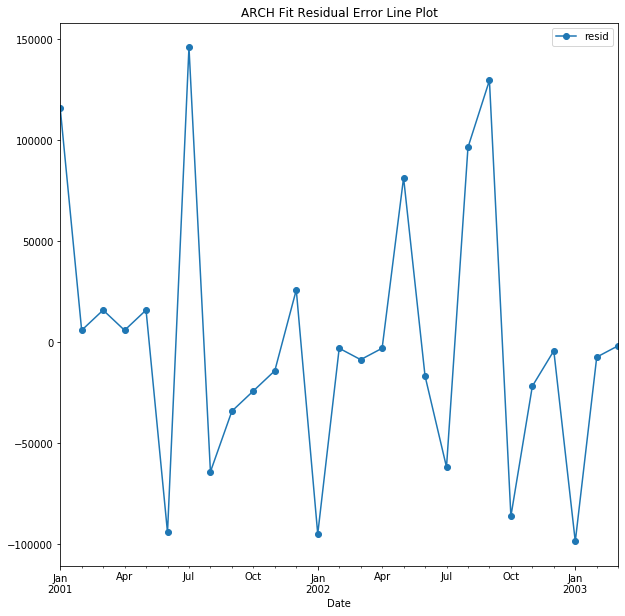

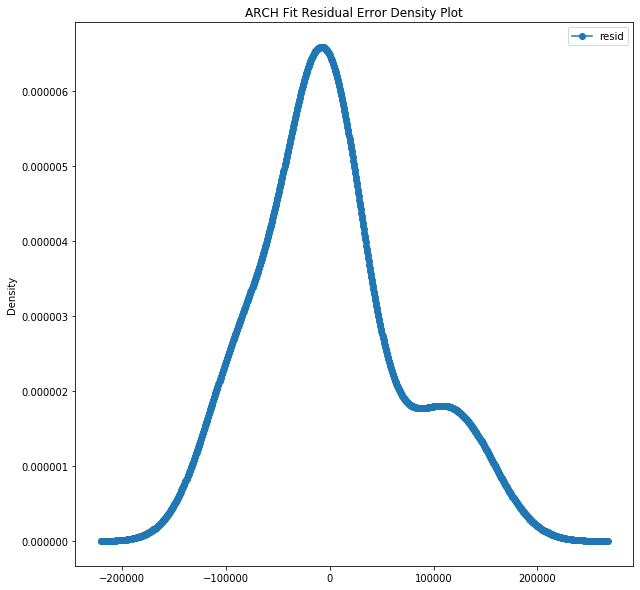

               resid
count      27.000000
mean        0.000043
std     66341.554958
min    -98595.118268
25%    -29115.419644
50%     -4255.986244
75%     15884.580353
max    145884.580348


In [46]:
# plot residual errors
residuals = pd.DataFrame( am.resid )
residuals.plot()
plt.title('ARCH Fit Residual Error Line Plot')
plt.show()

residuals.plot(kind='kde')
plt.title('ARCH Fit Residual Error Density Plot')
plt.show()
print(residuals.describe())

So as we can also confirm from the Autocorrelation plots above, the data contains Conditional Heteroscedasticity

Which indicates some space for optimization and better forecasting results!

In [132]:
from arch import arch_model

model = arch_model(sxmodel.resid(), p=1, o=1, q=1, dist='skewt')

am = model.fit()

am.summary()

Iteration:      1,   Func. Count:      9,   Neg. LLF: 337.64867856065337
Iteration:      2,   Func. Count:     19,   Neg. LLF: 337.439773001209
Iteration:      3,   Func. Count:     29,   Neg. LLF: 337.4019789680116
Iteration:      4,   Func. Count:     40,   Neg. LLF: 337.3759251944543
Iteration:      5,   Func. Count:     49,   Neg. LLF: 337.3680257391775
Iteration:      6,   Func. Count:     58,   Neg. LLF: 337.3098462374998
Iteration:      7,   Func. Count:     67,   Neg. LLF: 337.2119881254706
Iteration:      8,   Func. Count:     76,   Neg. LLF: 337.06303036449515
Iteration:      9,   Func. Count:     86,   Neg. LLF: 337.04884670583186
Iteration:     10,   Func. Count:     95,   Neg. LLF: 337.0454130830632
Iteration:     11,   Func. Count:    104,   Neg. LLF: 337.0445755942907
Iteration:     12,   Func. Count:    113,   Neg. LLF: 337.0441863334284
Iteration:     13,   Func. Count:    122,   Neg. LLF: 337.04356758690454
Iteration:     14,   Func. Count:    131,   Neg. LLF: 337.041

/home/youssef/.local/lib/python3.6/site-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.238e+09. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.0001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                         Constant Mean - GJR-GARCH Model Results                         
=========================================================================================
Dep. Variable:                              None   R-squared:                      -0.000
Mean Model:                        Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -336.880
Distribution:      Standardized Skew Student's t   AIC:                           687.761
Method:                       Maximum Likelihood   BIC:                           696.832
                                                   No. Observations:                   27
Date:                           Tue, Feb 11 2020   Df Residuals:                       20
Time:                                   11:52:27   Df Model:                            7
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         -3338.5852  1.946e+04     -0.172      0.864 [-4.147e+04,3.479e+04]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.1191e+09  1.785e+09      1.187      0.235 [-1.380e+09,5.618e+09]
alpha[1]       0.0139      0.146  9.506e-02      0.924      [ -0.272,  0.300]
gamma[1]      -0.0139      0.358 -3.882e-02      0.969      [ -0.715,  0.687]
beta[1]        0.4731      0.439      1.078      0.281      [ -0.387,  1.333]
                                 Distribution                                
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
nu           156.4256    191.769      0.816      0.415 [-2.194e+02,5.323e+02]
lambda         0.2935      0.319      0.920      0.358      [ -0.332,  0.919]
=============================================================================

Covariance estimator: robust
"""

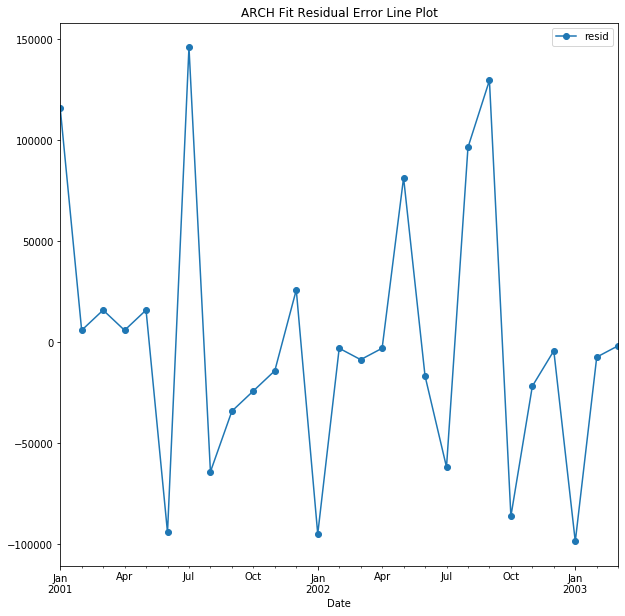

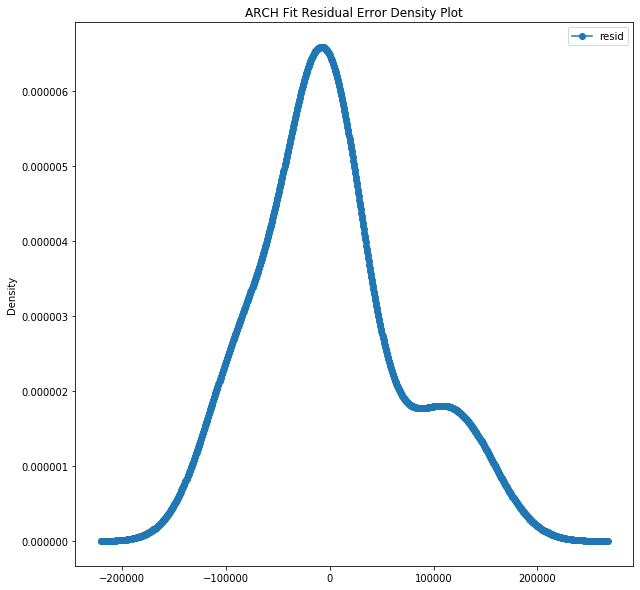

               resid
count      27.000000
mean       -0.037662
std     66341.554958
min    -98595.155973
25%    -29115.457350
50%     -4256.023950
75%     15884.542648
max    145884.542643


In [133]:
# plot residual errors
residuals = pd.DataFrame( am.resid )
residuals.plot()
plt.title('ARCH Fit Residual Error Line Plot')
plt.show()

residuals.plot(kind='kde')
plt.title('ARCH Fit Residual Error Density Plot')
plt.show()
print(residuals.describe())

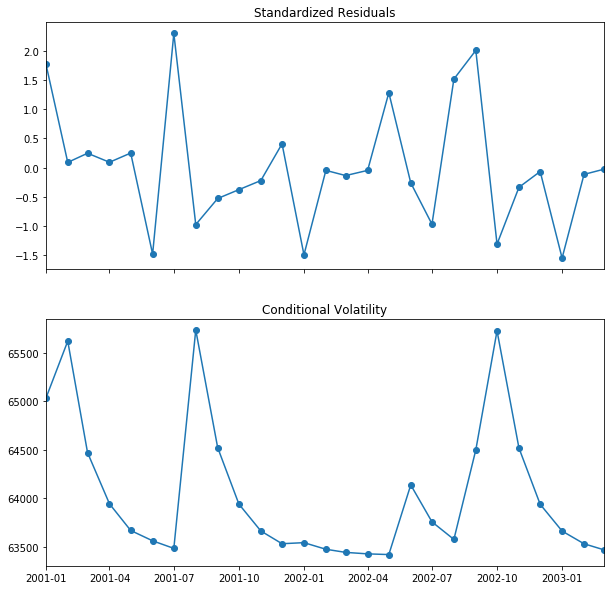

In [134]:
_= am.plot()

In [135]:
from arch import arch_model

model = arch_model(sxmodel.resid(), p=1, o=1, q=1, power=1.0, dist='skewt')

am = model.fit()

am.summary()

Iteration:      1,   Func. Count:      9,   Neg. LLF: 337.92311975929624
Iteration:      2,   Func. Count:     19,   Neg. LLF: 337.5452383472534
Iteration:      3,   Func. Count:     29,   Neg. LLF: 337.36290310348113
Iteration:      4,   Func. Count:     38,   Neg. LLF: 337.2399474257171
Iteration:      5,   Func. Count:     47,   Neg. LLF: 337.1454517163595
Iteration:      6,   Func. Count:     56,   Neg. LLF: 337.1269486221525
Iteration:      7,   Func. Count:     65,   Neg. LLF: 337.12347689207667
Iteration:      8,   Func. Count:     74,   Neg. LLF: 337.12308324743015
Iteration:      9,   Func. Count:     83,   Neg. LLF: 337.122900320265
Iteration:     10,   Func. Count:     92,   Neg. LLF: 337.122153295608
Iteration:     11,   Func. Count:    101,   Neg. LLF: 337.12051730160954
Iteration:     12,   Func. Count:    110,   Neg. LLF: 337.11653268743595
Iteration:     13,   Func. Count:    119,   Neg. LLF: 337.1084883737364
Iteration:     14,   Func. Count:    128,   Neg. LLF: 337.09

/home/youssef/.local/lib/python3.6/site-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.238e+09. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.0001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - TARCH/ZARCH Model Results                        
=========================================================================================
Dep. Variable:                              None   R-squared:                      -0.000
Mean Model:                        Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -336.983
Distribution:      Standardized Skew Student's t   AIC:                           687.966
Method:                       Maximum Likelihood   BIC:                           697.037
                                                   No. Observations:                   27
Date:                           Tue, Feb 11 2020   Df Residuals:                       20
Time:                                   11:52:54   Df Model:                            7
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         -3338.2196  1.847e+04     -0.181      0.857 [-3.955e+04,3.287e+04]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.2551e+04  3.015e+04      1.080      0.280 [-2.655e+04,9.165e+04]
alpha[1]       0.0547      0.163      0.336      0.737      [ -0.264,  0.374]
gamma[1]      -0.0547      0.378     -0.145      0.885      [ -0.795,  0.686]
beta[1]        0.4728      0.446      1.060      0.289      [ -0.401,  1.347]
                                 Distribution                                
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
nu           269.1337    398.477      0.675      0.499 [-5.119e+02,1.050e+03]
lambda         0.3178      0.316      1.005      0.315      [ -0.302,  0.938]
=============================================================================

Covariance estimator: robust
"""

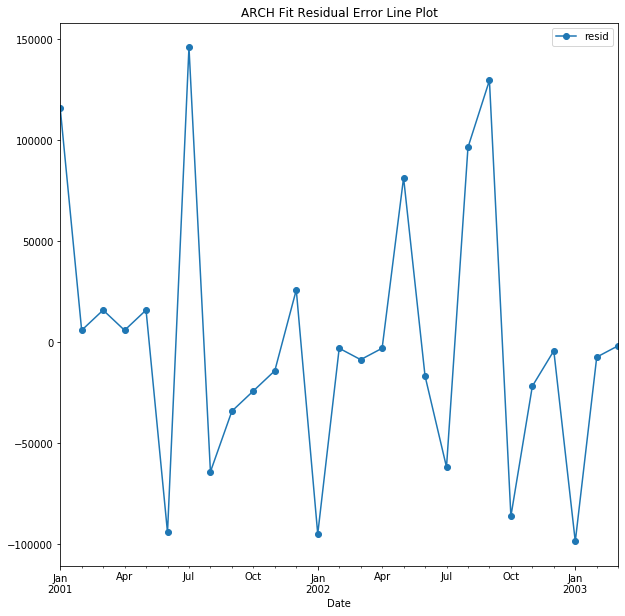

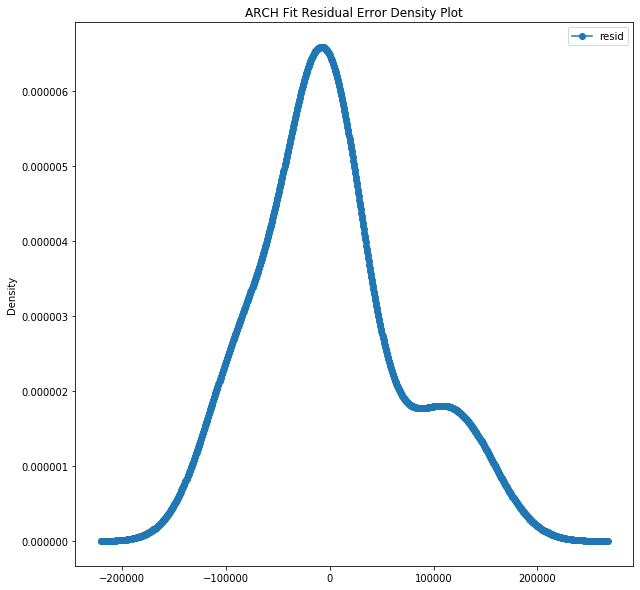

               resid
count      27.000000
mean       -0.403325
std     66341.554958
min    -98595.521637
25%    -29115.823013
50%     -4256.389613
75%     15884.176984
max    145884.176980


In [136]:
# plot residual errors
residuals = pd.DataFrame( am.resid )
residuals.plot()
plt.title('ARCH Fit Residual Error Line Plot')
plt.show()

residuals.plot(kind='kde')
plt.title('ARCH Fit Residual Error Density Plot')
plt.show()
print(residuals.describe())

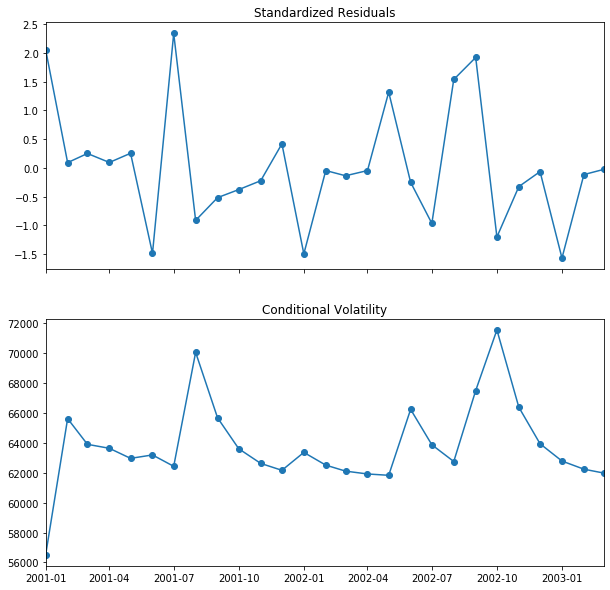

In [137]:
_ = am.plot()

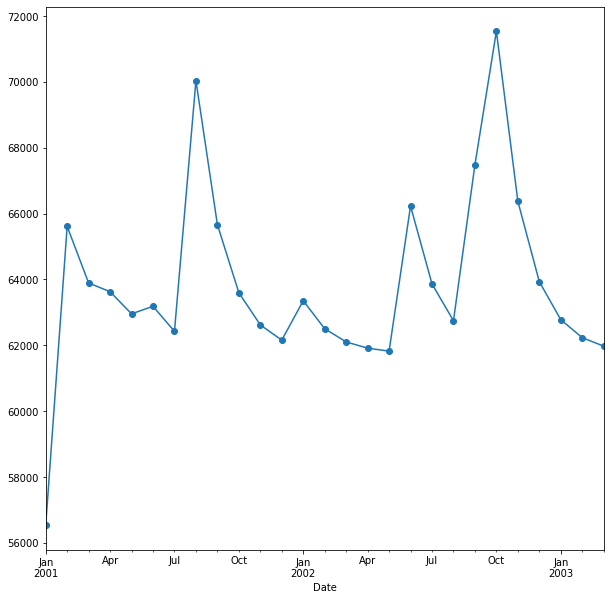

In [138]:
_= am.conditional_volatility.plot()

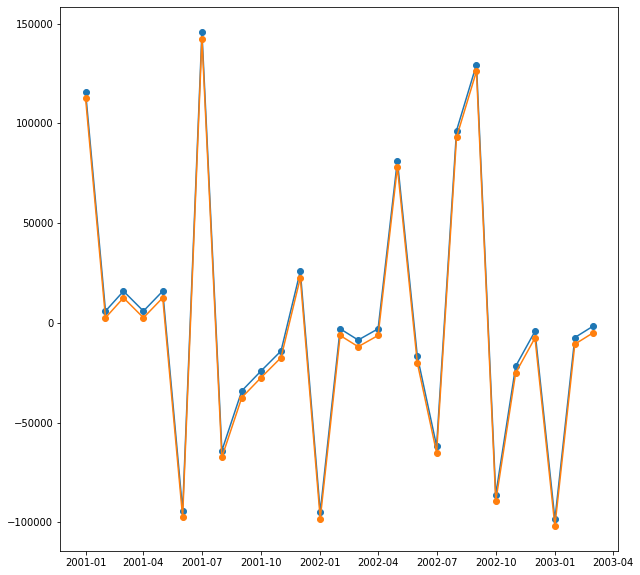

In [139]:
_ = plt.plot ( am.resid )
_ = plt.plot ( sxmodel.resid() )

In [140]:
am.resid

Date
2001-01-01    115884.176972
2001-02-01      5884.176986
2001-03-01     15884.176986
2001-04-01      5884.176986
2001-05-01     15884.176983
2001-06-01    -94115.823006
2001-07-01    145884.176980
2001-08-01    -64115.823013
2001-09-01    -34115.823015
2001-10-01    -24115.823011
2001-11-01    -14115.823012
2001-12-01     25884.176985
2002-01-01    -94888.134747
2002-02-01     -3002.466100
2002-03-01     -8629.427856
2002-04-01     -3002.466100
2002-05-01     81370.572143
2002-06-01    -16732.848533
2002-07-01    -61779.930691
2002-08-01     96386.266195
2002-09-01    129505.380925
2002-10-01    -86121.580829
2002-11-01    -21748.542586
2002-12-01     -4256.389613
2003-01-01    -98595.521637
2003-02-01     -7376.066131
2003-03-01     -1749.858043
Name: resid, dtype: float64

In [57]:
sxmodel.resid()

Date
2001-01-01    112545.957401
2001-02-01      2545.957415
2001-03-01     12545.957414
2001-04-01      2545.957414
2001-05-01     12545.957411
2001-06-01    -97454.042578
2001-07-01    142545.957408
2001-08-01    -67454.042584
2001-09-01    -37454.042587
2001-10-01    -27454.042582
2001-11-01    -17454.042584
2001-12-01     22545.957413
2002-01-01    -98226.354318
2002-02-01     -6340.685671
2002-03-01    -11967.647428
2002-04-01     -6340.685672
2002-05-01     78032.352571
2002-06-01    -20071.068104
2002-07-01    -65118.150263
2002-08-01     93048.046624
2002-09-01    126167.161354
2002-10-01    -89459.800401
2002-11-01    -25086.762158
2002-12-01     -7594.609184
2003-01-01   -101933.741208
2003-02-01    -10714.285703
2003-03-01     -5088.077615
dtype: float64

In [73]:
import datetime as dt
test = am.forecast(horizon = 36, method='simulation', start=dt.datetime(2001,1,1))

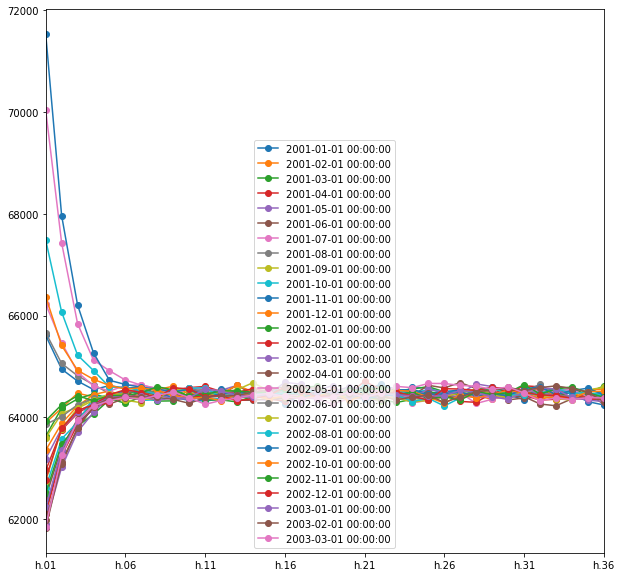

In [174]:
_ = [( test.variance.dropna().iloc[i]** (1/2) ).plot() for i in range(len(test.variance.dropna()))]
_ = plt.legend()

In [165]:
d = test.variance.dropna().iloc[-1] ** (1/2)

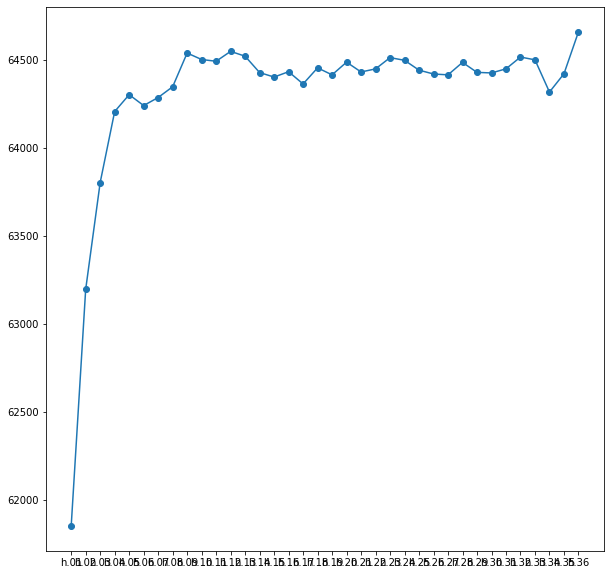

In [166]:
_ = plt.plot( d )
_ = d

In [178]:
'p-value = ' + str(het_arch ( d )[1])

'p-value = 0.05265540324324114'

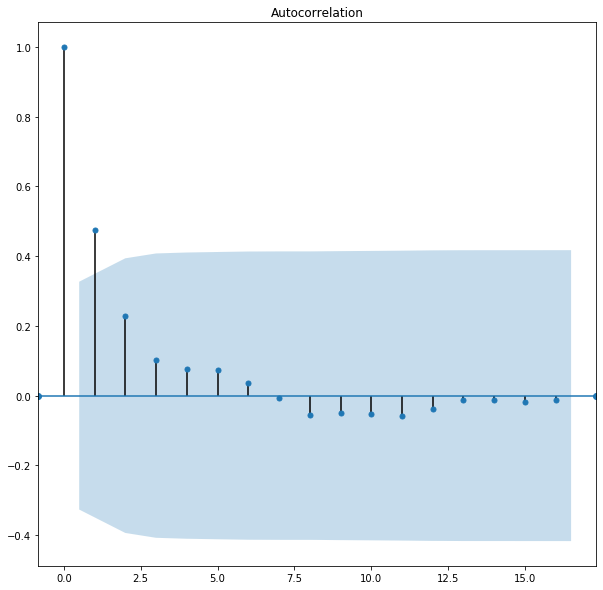

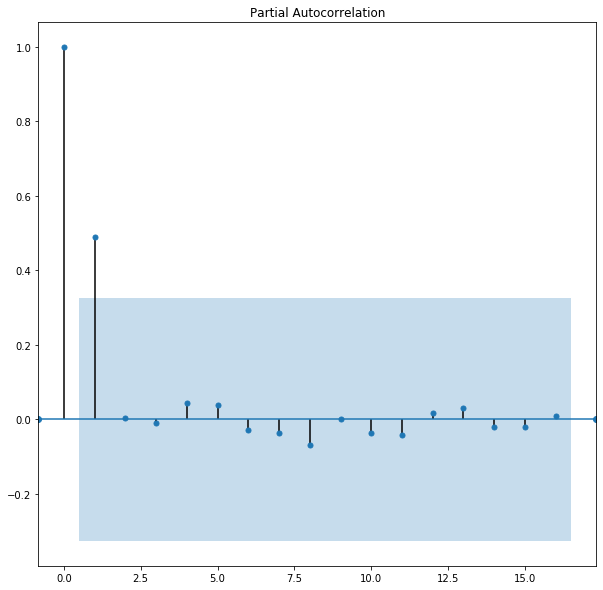

In [170]:
_ = plot_acf  ( d )
_ = plot_pacf ( d )

As We see at the last two cells, now we have an explanation of why there were a structure inside the residuals